In [1]:
include("cruise_control.jl")

fullsolve (generic function with 1 method)

In [1]:
using HybridSystems
include(joinpath(dirname(dirname(pathof(HybridSystems))), "examples", "cruise_control.jl"));

In [33]:
function constant(scaling)
    va = 15.6 * scaling
    vb = 24.5 * scaling
    vc = 29.5 * scaling
    v = (va, vb, vc)
    U = 4.0 * scaling
    D = 0.5 * scaling
    vmin = 5.0 * scaling
    return D, U, vmin, v
end
D, U, vmin, v = constant(1.0)
D = 1.0
U = 1.0
vmin = 1.0
v = (3.0, 4.0, 5.0)
T = 2
N = 1 + (T+1) * length(v)
m = 1.0
m0 = 1.0 #500;
H = 1.0 #0.8;
function system(N, M; sym=false, vmax = 35., v=v)
    #return cruise_control_example(N, M, vmin = vmin, vmax=vmax, v=v, U=U, H=H, D=D, T=T, sym=sym, m0 = m0);
    return cruise_control_example(N, M, vmin = 1.0, vmax=vmax, v=v,
        U=1.0, H=1.0, D=1.0, T=T, sym=sym, m0 = 1.0, ks=1.0, m=1.0, kd=1.0)
end
_vec(M, d, v, u) = [repeat([d, v], M); v; u]
#Δv = (v[1] - vmin) / 2
Δv = (15.6 - 5) / 2
# |string_elongation| < D
# |acceleration| < U
sym_rect(M) = _vec(M, D, 1.0, U) # _vec(M, D, Δv, U)

sym_rect (generic function with 1 method)

In [3]:
system(1, 1; sym=true).modes[1]

ConstrainedDiscreteIdentitySystem{DefaultPolyhedron{Float64,Polyhedra.Intersection{Float64,Array{Float64,1},Int64},Polyhedra.Hull{Float64,Array{Float64,1},Int64}}}(4, HalfSpace([-1.0, 0.0, 0.0, 0.0], 1.0) ∩ HalfSpace([1.0, 0.0, 0.0, 0.0], 1.0) ∩ HalfSpace([0.0, 0.0, 0.0, -1.0], 1.0) ∩ HalfSpace([0.0, 0.0, 0.0, 1.0], 1.0) ∩ HalfSpace([0.0, 1.0, 0.0, 0.0], 3.0) ∩ HalfSpace([0.0, 0.0, 1.0, 0.0], 3.0) ∩ HalfSpace([0.0, -1.0, 0.0, 0.0], 3.0) ∩ HalfSpace([0.0, 0.0, -1.0, 0.0], 3.0))

In [4]:
system(1, 1; sym=true).resetmaps[1].A

4×4 Array{Float64,2}:
 1.0  -0.5  0.5  0.0
 0.5   0.5  0.5  0.0
 0.5   0.5  0.5  0.5
 0.0   0.0  0.0  0.0

In [5]:
sym_rect(1)

4-element Array{Float64,1}:
 1.0
 5.3
 5.3
 1.0

In [6]:
using SetProg
using SwitchOnSafety
const SOS = SwitchOnSafety;

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.0/SwitchOnSafety/PA0qe.ji for SwitchOnSafety [4b7ae085-addf-5b2e-b0f2-71171a701510]
└ @ Base loading.jl:1190


In [4]:
using CSDP
sdp_factory = with_optimizer(CSDP.Optimizer);

In [5]:
using SCS
sdp_factory = with_optimizer(SCS.Optimizer);

In [2]:
import Mosek
using MathOptInterfaceMosek
sdp_factory = with_optimizer(MosekOptimizer, QUIET=true, INTPNT_SCALING=3);

In [8]:
using LightGraphs
const MOI = JuMP.MathOptInterface
function symsolve(M, set_variable; volume_heuristic=set -> L1_heuristic(set, sym_rect(M)))
    hs = system(M, T, N=1, sym=true, vmax = 1.0, v=(1.0,))
    # Shift interval 5 <= v <= 15.6 -> -5.3 <= v <= 5.3
    sets = invariant_sets(hs, sdp_factory, [set_variable], volume_heuristic=volume_heuristic)
    [SOS.SetProg.Sets.Translation(set, _vec(M, 0, 2.0, 0)) for set in sets]
end
function fullsolve(T, M, setvar::Function;
                   volume_heuristic=set -> L1_heuristic(set, sym_rect(M)),
                   oneshot = false,
                   onlyone = false)
    hs = system(M, T);
    function hv(v)
        h = zeros(statedim(hs, 1))
        for i in 1:M
            h[2i] = (vmin .+ v) / 2
        end
        h[2M+1] = (vmin .+ v) / 2
        h
    end
    habc = SOS.SetProg.InteriorPoint.(hv.(v))
    ha = habc[1]
    hi = [ha, ha, ha, ha, ha, ha, ha, ha, ha, ha]
    set_variables = map(setvar, hi)
    if oneshot
        λ = Dict(t => 1.0 for t in transitions(hs))
    else
        λ = Dict(t => 1.0 for t in transitions(hs) if source(hs, t) == target(hs, t))
    end
    if oneshot
        return invariant_sets(hs, sdp_factory, set_variables, λ = λ, volume_heuristic=volume_heuristic);
    else
        sets = Vector{SwitchOnSafety.SetProg.Sets.AbstractSet{Float64}}(undef, N)
        for i in (onlyone ? (1:1) : (1:N))
            invariant_sets!(sets, i:i, hs, sdp_factory, set_variables, λ = λ, enabled=1:i,
                            volume_heuristic=volume_heuristic)
        end
        return sets
    end
end

fullsolve (generic function with 1 method)

# Symmetric

In [3]:
# M -> sets
sym_ellipsoids_det = Dict{Int, Vector{SOS.SetProg.Sets.AbstractSet{Float64}}}()

Dict{Int64,Array{SetProg.Sets.AbstractSet{Float64},1}} with 0 entries

In [4]:
for M in 1:10
    sym_ellipsoids_det[M] = symsolve(M, Ellipsoid(symmetric=true),
                                 volume_heuristic=nth_root)
end

MOI.get(model, MOI.SolveTime()) = 0.004478931427001953
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.6906961080519046
MOI.get(model, MOI.SolveTime()) = 0.0058019161224365234
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.7542156649316701
MOI.get(model, MOI.SolveTime()) = 0.010805130004882812
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.7898383564491525
MOI.get(model, MOI.SolveTime()) = 0.023098230361938477
JuMP.termination_status(model) = OPTIMAL::Te

In [5]:
# M -> sets
sym_ellipsoids_tr = Dict{Int, Vector{SOS.SetProg.Sets.AbstractSet{Float64}}}()

Dict{Int64,Array{SetProg.Sets.AbstractSet{Float64},1}} with 0 entries

In [6]:
for M in 1:10
    sym_ellipsoids_tr[M] = symsolve(M, Ellipsoid(symmetric=true))
end

MOI.get(model, MOI.SolveTime()) = 0.001093149185180664
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 2.6666666666666394
MOI.get(model, MOI.SolveTime()) = 0.0014870166778564453
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 3.9999999999726006
MOI.get(model, MOI.SolveTime()) = 0.0021049976348876953
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 5.333333333061911
MOI.get(model, MOI.SolveTime()) = 0.003036022186279297
JuMP.termination_status(model) = OPTIMAL::Te

In [7]:
# (d, M) -> sets
sym_polysets = Dict{Tuple{Int, Int}, Vector{SOS.SetProg.Sets.AbstractSet{Float64}}}()
function poly(d, M)
    sym_polysets[(d, M)] = symsolve(M, PolySet(convex=true, degree=d, symmetric=true))
end

poly (generic function with 1 method)

In [8]:
for M in 1:10
    poly(2, M)
end

MOI.get(model, MOI.SolveTime()) = 0.0018889904022216797
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 21.333333333410017
MOI.get(model, MOI.SolveTime()) = 0.0034689903259277344
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 128.0000000021801
MOI.get(model, MOI.SolveTime()) = 0.0052759647369384766
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 682.6666666713763
MOI.get(model, MOI.SolveTime()) = 0.010274887084960938
JuMP.termination_status(model) = OPTIMAL::Te

In [9]:
@time poly(4, 1);

MOI.get(model, MOI.SolveTime()) = 0.03703594207763672
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 76.79999677466857
  0.096362 seconds (162.69 k allocations: 9.514 MiB, 5.57% gc time)


In [10]:
@time poly(6, 1);

MOI.get(model, MOI.SolveTime()) = 0.6681869029998779
STALL
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 414.5099078327513
  0.724092 seconds (182.68 k allocations: 17.354 MiB, 1.74% gc time)


In [11]:
@time poly(8, 1);

MOI.get(model, MOI.SolveTime()) = 9.690335988998413
STALL
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 2898.6558988665647
  9.796740 seconds (491.35 k allocations: 68.389 MiB, 0.22% gc time)


# Non-homogeneous

In [7]:
# M -> sets
ellipsoids_det = Dict{Int, Vector{SOS.SetProg.Sets.AbstractSet{Float64}}}()

Dict{Int64,Array{SetProg.Sets.AbstractSet{Float64},1}} with 0 entries

In [8]:
for M in 1:10
    ellipsoids_det[M] = fullsolve(T, M, h -> Ellipsoid(point=h),
                     volume_heuristic=nth_root, oneshot=false, onlyone=true)
end

MOI.get(model, MOI.SolveTime()) = 0.007884979248046875
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.0007378441273952033
MOI.get(model, MOI.SolveTime()) = 0.015391111373901367
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.00035270040967755
MOI.get(model, MOI.SolveTime()) = 0.0436098575592041
STALL
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.000178232388157923
MOI.get(model, MOI.SolveTime()) = 0.07949018478393555
STALL
JuMP.termination_status

In [8]:
# M -> sets
ellipsoids_tr = Dict{Int, Vector{SOS.SetProg.Sets.AbstractSet{Float64}}}()

Dict{Int64,Array{SetProg.Sets.AbstractSet{Float64},1}} with 0 entries

In [9]:
for M in 1:10
    ellipsoids_tr[M] = fullsolve(T, M, h -> Ellipsoid(point=h),
                                 oneshot=false, onlyone=true)
end

MOI.get(model, MOI.SolveTime()) = 0.0036468505859375
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.0062879016788270885
MOI.get(model, MOI.SolveTime()) = 0.006290912628173828
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.006348923400704833
MOI.get(model, MOI.SolveTime()) = 0.015575885772705078
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.006815868635075748
MOI.get(model, MOI.SolveTime()) = 0.02512192726135254
JuMP.termination_status(model) = OPTIMAL:

In [43]:
# (d, M) -> sets
polysets = Dict{Tuple{Int, Int}, Vector{SOS.SetProg.Sets.AbstractSet{Float64}}}()
function poly(d, M)
    polysets[(d, M)] = fullsolve(T, M, h -> PolySet(convex=true, degree=d, point=h),
                                 oneshot=false, onlyone=true)
end

poly (generic function with 1 method)

In [46]:
for M in 1:10
    poly(2, M)
end

MOI.get(model, MOI.SolveTime()) = 0.0036978721618652344
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.0008953900538050838
MOI.get(model, MOI.SolveTime()) = 0.007388114929199219
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.0013646256331211531
MOI.get(model, MOI.SolveTime()) = 0.012610912322998047
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.0022112154748826496
MOI.get(model, MOI.SolveTime()) = 0.0258939266204834
JuMP.termination_status(model) = OPTI

In [44]:
@time poly(4, 1);

MOI.get(model, MOI.SolveTime()) = 0.04555201530456543
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 6.772987696151774e-6
  6.040348 seconds (14.91 M allocations: 761.452 MiB, 7.47% gc time)


In [24]:
@time poly(4, 2);

MOI.get(model, MOI.SolveTime()) = 1.6126079559326172
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 1.1507778118401987e-5
  1.877606 seconds (879.51 k allocations: 144.101 MiB, 4.00% gc time)


In [13]:
@time poly(4, 2);

MOI.get(model, MOI.SolveTime()) = 6.242372989654541
JuMP.termination_status(model) = Success::TerminationStatusCode = 1
JuMP.primal_status(model) = FeasiblePoint::ResultStatusCode = 1
JuMP.dual_status(model) = FeasiblePoint::ResultStatusCode = 1
JuMP.objective_value(model) = 1.1500712388261522e-5
  6.410467 seconds (983.38 k allocations: 157.858 MiB, 0.73% gc time)


In [15]:
@time poly(6, 1);

MOI.get(model, MOI.SolveTime()) = 3.108872890472412
STALL
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 3.5122702706947064e-7
  3.264221 seconds (916.49 k allocations: 164.066 MiB, 1.31% gc time)


In [14]:
@time poly(6, 1);

MOI.get(model, MOI.SolveTime()) = 52.67625093460083
STALL
JuMP.termination_status(model) = SlowProgress::TerminationStatusCode = 14
JuMP.primal_status(model) = FeasiblePoint::ResultStatusCode = 1
JuMP.dual_status(model) = FeasiblePoint::ResultStatusCode = 1
JuMP.objective_value(model) = 9.996768542488537e-7
 52.865089 seconds (1.23 M allocations: 193.334 MiB, 0.10% gc time)


In [16]:
hs.resetmaps[1]

UndefVarError: UndefVarError: hs not defined

In [27]:
set = polysets[(6, 1)][1]
for hs in halfspaces(stateset(hs, 1))
    @show hs
    x = set.set.p(SetProg.Sets.perspective_variable(set) => -hs.β, SetProg.Sets.space_variables(set) => hs.a)
    @show x
    @show x < 1e-7
end

hs = HalfSpace([-1.0, 0.0, 0.0, 0.0], 0.5)
x = 8.331643470057758e-9
x < 1.0e-7 = true
hs = HalfSpace([1.0, 0.0, 0.0, 0.0], 0.5)
x = 3.3089699437148976e-9
x < 1.0e-7 = true
hs = HalfSpace([0.0, 0.0, 0.0, -1.0], 4.0)
x = -4.232171244320486e-5
x < 1.0e-7 = true
hs = HalfSpace([0.0, 0.0, 0.0, 1.0], 4.0)
x = -3.7236041968422885e-5
x < 1.0e-7 = true
hs = HalfSpace([0.0, -1.0, 0.0, 0.0], -5.0)
x = -0.0002939379554248167
x < 1.0e-7 = true
hs = HalfSpace([0.0, 0.0, -1.0, 0.0], -5.0)
x = -0.00041380841537877466
x < 1.0e-7 = true
hs = HalfSpace([0.0, 1.0, 0.0, 0.0], 15.6)
x = 0.37828705273760593
x < 1.0e-7 = false
hs = HalfSpace([0.0, 0.0, 1.0, 0.0], 15.6)
x = 0.35481234408593015
x < 1.0e-7 = false


In [18]:
set = polysets[(6, 1)][1]
for hs in halfspaces(stateset(hs, 1))
    @show hs
    @show set.p(set.z => -hs.β, set.x => hs.a)
    @show set.p(set.z => -hs.β, set.x => hs.a) < 1e-7
end

hs = HalfSpace([-1.0, 0.0, 0.0, 0.0], 0.5)
set.p(set.z => -(hs.β), set.x => hs.a) = 7.258554048221158e-8
set.p(set.z => -(hs.β), set.x => hs.a) < 1.0e-7 = true
hs = HalfSpace([1.0, 0.0, 0.0, 0.0], 0.5)
set.p(set.z => -(hs.β), set.x => hs.a) = 9.356120268743195e-8
set.p(set.z => -(hs.β), set.x => hs.a) < 1.0e-7 = true
hs = HalfSpace([0.0, 0.0, 0.0, -1.0], 4.0)
set.p(set.z => -(hs.β), set.x => hs.a) = -7.341635924066887e-6
set.p(set.z => -(hs.β), set.x => hs.a) < 1.0e-7 = true
hs = HalfSpace([0.0, 0.0, 0.0, 1.0], 4.0)
set.p(set.z => -(hs.β), set.x => hs.a) = -1.400969402629937e-5
set.p(set.z => -(hs.β), set.x => hs.a) < 1.0e-7 = true
hs = HalfSpace([0.0, -1.0, 0.0, 0.0], -5.0)
set.p(set.z => -(hs.β), set.x => hs.a) = -0.00015975016257570307
set.p(set.z => -(hs.β), set.x => hs.a) < 1.0e-7 = true
hs = HalfSpace([0.0, 0.0, -1.0, 0.0], -5.0)
set.p(set.z => -(hs.β), set.x => hs.a) = -0.0003274353820358067
set.p(set.z => -(hs.β), set.x => hs.a) < 1.0e-7 = true
hs = HalfSpace([0.0, 1.0, 0.0, 0.

In [25]:
poly(8, 1)

┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP /home/blegat/.julia/dev/JuMP/src/JuMP.jl:614


MOI.get(model, MOI.SolveTime()) = 255.13594102859497
STALL
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.00013345920872077436


10-element Array{SetProg.Sets.AbstractSet{Float64},1}:
    SetProg.Sets.PerspectiveDual{Float64,SetProg.Sets.PerspectiveConvexPolynomialSet{Float64,Float64}}(SetProg.Sets.PerspectiveConvexPolynomialSet{Float64,Float64}(8, SumOfSquares.MatPolynomial{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([216.401 30.8102 … 0.29016 0.153923; 30.8102 18.4382 … 0.0192266 0.034118; … ; 0.29016 0.0192266 … 0.0744437 0.0343486; 0.153923 0.034118 … 0.0343486 0.257669], DynamicPolynomials.Monomial{true}[z⁴, z³x₁, z³x₂, z³x₃, z³x₄, z²x₁², z²x₁x₂, z²x₁x₃, z²x₁x₄, z²x₂²  …  x₂²x₄², x₂x₃³, x₂x₃²x₄, x₂x₃x₄², x₂x₄³, x₃⁴, x₃³x₄, x₃²x₄², x₃x₄³, x₄⁴]), 4.452527457633574e-8z⁸ - 8.978286415066446e-7z⁷x₁ + 2.7775574404679854e-5z⁷x₂ + 2.6700707072982987e-5z⁷x₃ - 2.455591214078306e-7z⁷x₄ + 4.9688252937801655e-6z⁶x₁² - 6.704517050952472e-5z⁶x₁x₂ - 6.396219849934787e-5z⁶x₁x₃ - 2.26892238312428e-7z⁶x₁x₄ + 0.0008343186526858594z⁶x₂² + 0.0016510818111969354z⁶x₂x₃ - 3.300761338542634e-5z

# Plots

In [12]:
using Plots
gr()

Plots.GRBackend()

In [13]:
function pli(hs, p, i, I = [statedim(hs, 1)-1, statedim(hs, 1)])
    @assert length(I) == 2
    Plots.plot(Polyhedra.project(hs.invariants[i], I))
    Plots.plot!(proj(p[i], I))
end

pli (generic function with 2 methods)

In [14]:
hs = system(1, T);
d = statedim(hs, 1);
_savefig(name, ext="eps") = Plots.savefig("/home/blegat/Dropbox/Research/Images/CruiseControl$name.$ext")

_savefig (generic function with 2 methods)

In [25]:
Id(d) = [d-1, d]
include("colors.jl")
function base_plot()
    xmargin = 0.3
    ymargin = 0.3
    Plots.plot(guidefont=Plots.font(18), tickfont=Plots.font(16), size=(900, 600), grid=false,
               #xlims=(vmin-xmargin, v[1]+xmargin), ylims=(-U-ymargin, U+ymargin),
               xlabel="Truck speed [m/s]", ylabel="Truck acceleration [m/s²]")
        #xticks = [5, 7, 9, 11, 13, 15.6])
    Plots.plot!(Polyhedra.project(stateset(hs, 1), Id(d)), color=:white)
end
function set_plot(sets, M, color, alpha=1.0; kws...)
    dd = 2M+2
    Plots.plot!(project(sets[1], Id(dd)); kws..., fillalpha=alpha, color=color)
end

set_plot (generic function with 2 methods)

In [22]:
function fullplot(sets, Ms = [1, 2, 6, 10])
    base_plot()
    colors = [re, gre,
              gre, gre,
              blu, blu,
              blu, blu,
              ora, ora]
    alpha = fill(1., 10)
    for M in Ms
        set_plot(sets[M], M, colors[M], alpha[M])
    end
    fontsize = 24
    Plots.annotate!(5.4,  2.7, Plots.text("1", fontsize, colors[1]))
    Plots.annotate!(5.2, -1.43, Plots.text("2", fontsize, colors[2]))
    Plots.annotate!(6.3, -2.92, Plots.text("6", fontsize, colors[6]))
    Plots.annotate!(7.45, -3.75, Plots.text("10", fontsize, colors[10]))
    #@show inv(det(p[N].Q))
    #Plots.plot!(proj(p[N], I))
    #_savefig("Sets")
    Plots.plot!()
end

fullplot (generic function with 2 methods)

In [22]:
fullplot(ellipsoids_det, [1])

UndefVarError: UndefVarError: fullplot not defined

In [23]:
fullplot(ellipsoids_tr, [1])

UndefVarError: UndefVarError: fullplot not defined

(set.p).x = DynamicPolynomials.Monomial{true}[x₁², x₁x₂, x₁x₃, x₁x₄, x₂², x₂x₃, x₂x₄, x₃², x₃x₄, x₄²]
(set.p).x[K] = DynamicPolynomials.Monomial{true}[x₃², x₃x₄, x₄²]
typeof((set.p).x[K]) = DynamicPolynomials.MonomialVector{true}
polynomial(p) = 0.9999999999075738x₃⁴ + 3.9998683740124537x₃³x₄ + 5.999999754953199x₃²x₄² + 3.9998633400836563x₃x₄³ + 0.9999999999096877x₄⁴
subs(set.p, vars => zeros(length(vars))) = 0.9999999999075738x₃⁴ + 3.9998683740124537x₃³x₄ + 5.999999754953199x₃²x₄² + 3.9998633400836563x₃x₄³ + 0.9999999999096877x₄⁴
(set.p).x = DynamicPolynomials.Monomial{true}[x₁³, x₁²x₂, x₁²x₃, x₁²x₄, x₁x₂², x₁x₂x₃, x₁x₂x₄, x₁x₃², x₁x₃x₄, x₁x₄², x₂³, x₂²x₃, x₂²x₄, x₂x₃², x₂x₃x₄, x₂x₄², x₃³, x₃²x₄, x₃x₄², x₄³]
(set.p).x[K] = DynamicPolynomials.Monomial{true}[x₃³, x₃²x₄, x₃x₄², x₄³]
typeof((set.p).x[K]) = DynamicPolynomials.MonomialVector{true}
polynomial(p) = 0.9999999622769065x₃⁶ + 5.974779875687406x₃⁵x₄ + 14.999565425160903x₃⁴x₄² + 19.916642923941254x₃³x₄³ + 14.998227487044433x₃²x₄⁴ +

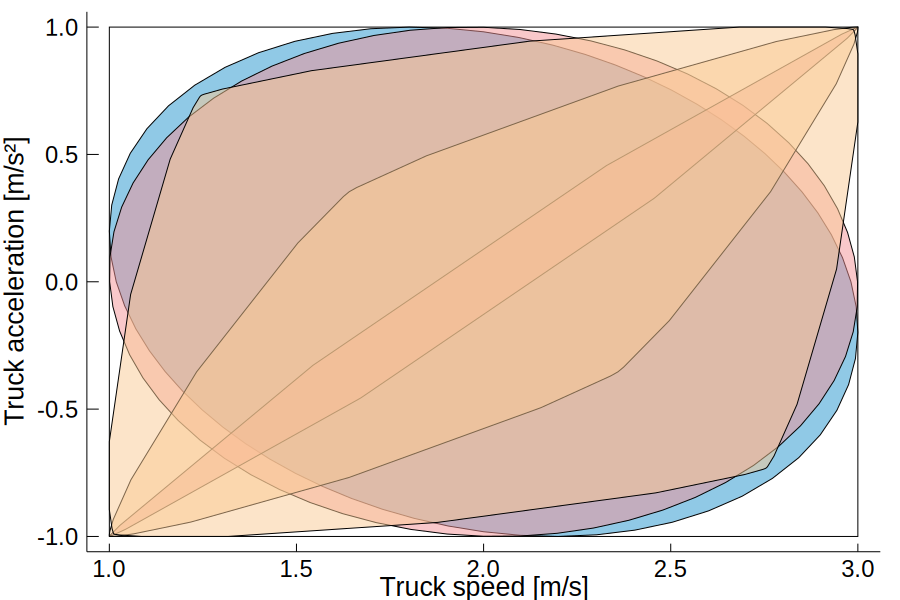

In [30]:
base_plot()
set_plot(sym_ellipsoids_det[1], 1, blu, 0.5)
set_plot(sym_ellipsoids_tr[1], 1, re, 0.5)
set_plot(sym_polysets[(4, 1)], 1, re, 0.5)
set_plot(sym_polysets[(6, 1)], 1, ora, 0.5)
set_plot(sym_polysets[(8, 1)], 1, ora, 0.5)
#Plots.savefig("/home/blegat/Dropbox/Research/Images/CruiseControlQuartic.png")

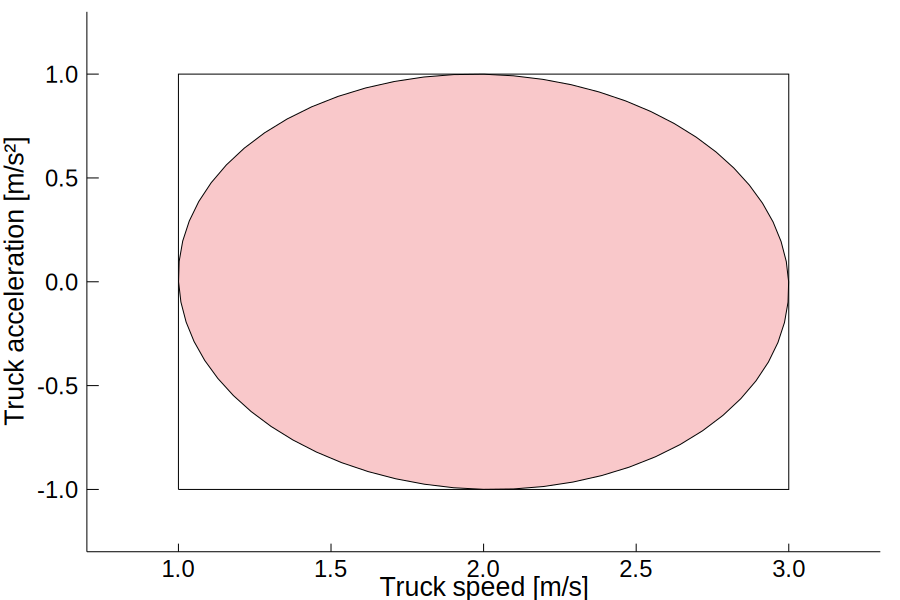

In [46]:
set_plot(sym_ellipsoids_tr[1], 1, re, 0.5)

In [53]:
base_plot()
set_plot(ellipsoids_det[1], 1, blu, 0.5)
set_plot(ellipsoids_tr[1], 1, re, 0.5)
#set_plot(polysets[(4, 1)], 1, gre, 0.5)
set_plot(polysets[(4, 1)], 1, gre, 0.5)
#set_plot(polysets[(6, 1)], 1, ora, 0.5)
#Plots.savefig("/home/blegat/Dropbox/Research/Images/CruiseControlQuartic.png")

UndefVarError: UndefVarError: ellipsoids_det not defined

In [14]:
fullplot(Dict(M => polysets[(4, M)] for M in 1:2), [1, 2])

UndefVarError: UndefVarError: fullplot not defined

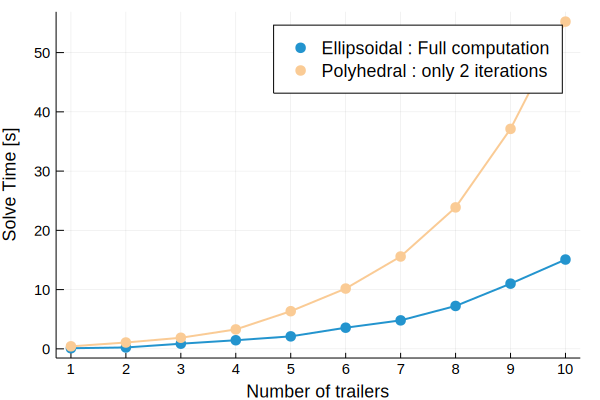

In [12]:
MM = 1:10
tell = [0.10468482971191406, 0.2330489158630371, 0.8677887916564941, 1.4519941806793213, 2.107150077819824, 3.5698659420013428, 4.80554986000061, 7.2393341064453125, 11.002917051315308, 15.073602199554443]
# 0.115419   0.245829   0.699803
# 1.41012    0.583312   1.60318 
# 1.63905    1.34177    3.57714 
# 2.93782    2.6325     5.64993 
# 2.4405     3.54338    9.20356 
# 3.57665    6.54242   16.2175  
# 5.81741   11.6776    27.5883  
# 6.79864   17.2622    45.1504  
# 9.08597   29.3919    69.7584  
# 0.0        0.0        0.0
tpoly2 =[
 0.13857    0.34833    0.885522
 0.245551   0.613526   2.01404 
 0.418676   1.16248    3.58055 
 0.814852   2.05653    5.71168 
 1.17044    2.95415    8.6016  
 1.76629    4.74113   11.3175  
 2.31273    6.6922    16.0757  
 2.88756    8.71237   22.6182  
 3.67838   11.8209    29.5     
 4.8712    16.119     41.0898]
tpoly = [ # H redundancy removal, CDDLib only, Dell laptop
  0.13682    0.290317
  0.424803   0.646405
  0.637992   1.2339 
  0.994851   2.28653 
  2.59906    3.7554  
  3.39291    6.78438 
  4.60605   10.9812  
  6.43151   17.4433  
  8.70048   28.4263  
 12.212     43.0176
]
# colors taken from https://previews.123rf.com/images/capacitorphoto/capacitorphoto1410/capacitorphoto141000191/32438941-Graph-Icon-color-set-illustration--Stock-Vector.jpg
red = Plots.RGBA(((0xf5, 0x92, 0x97) ./ 255)...)
gre = Plots.RGBA(((0xcb, 0xdf, 0x80) ./ 255)...)
blu = Plots.RGBA(((0x23, 0x94, 0xce) ./ 255)...)
ora = Plots.RGBA(((0xfa, 0xcb, 0x95) ./ 255)...)
yel = Plots.RGBA(((0xf2, 0xf0, 0x8b) ./ 255)...)
#font = ("sans-serif",12,:hcenter,:vcenter,0.0,Plots.RGB{Plots.U8}(0.0,0.0,0.0))
w = 2
ms = 6
Plots.plot(xlabel = "Number of trailers", ylabel="Solve Time [s]", xticks=1:10, tickfont=Plots.font(10), legendfont=Plots.font(12), guidefont=Plots.font(12))
Plots.plot!(MM, tell, color=blu, label="", linewidth=w)
Plots.scatter!(MM, tell, color=blu, markersize=6, markerstrokewidth=0, label="Ellipsoidal : Full computation")
Plots.plot!(MM, sum(tpoly[:,1:2], dims=2), color=ora, label="", linewidth=w)
Plots.scatter!(MM, sum(tpoly[:,1:2], dims=2), color=ora, markersize=6, markerstrokewidth=0, label="Polyhedral : only 2 iterations")
#_savefig("Benchmark", "png")
Plots.plot!()

In [ ]:
using JuMP
const MOI = MathOptInterface

$(x-c)^T Q (x-c) \le 1 \Leftrightarrow \lVert L(x-c) \rVert \le 1 \Leftrightarrow (1, L(x-c)) \text{ SOC}$

In [ ]:
function elltosoc(p::SOS.Ellipsoid)
    U, S, V = svd(p.Q)
    L = diagm(sqrt.(S)) * V'
    @show p.c
    x -> L * (x - p.c)
end
soc = elltosoc.(fullsolve(T, M, false, false))

In [ ]:
using JuMP
const MOI = MathOptInterface

function mpcstep(modes, x0, y0, usesoc, usetol)
    m = Model()
    nt = length(modes)
    @variable m y[1:nt]
    @variable m x[1:nt, 1:d]
    @variable m u[1:(nt-1)]
    @constraint m x[1, :] .== x0
    @constraint m y[1] == y0
    if usetol
        @variable m tol >= 0
    end

    for i in 1:nt
        q = modes[i]
        for h in ineqs(hs.invariants[q])
            @constraint m dot(x[i, :], h.a) <= h.β + (usetol ? tol : 0.)
        end
        if usesoc
            @constraint m [1; soc[q](x[i, :])] in MOI.SecondOrderCone(1+d)
        end
        if i < nt
            s = modes[i+1]
            σ = symbol(hs.automaton, LightGraphs.Edge(q, s))
            r = hs.resetmaps[σ]
            @constraint m x[i+1, :] .== r.A * x[i, :] + r.B * u[i]
            if σ == 1
                @constraint m y[i+1] == y[i] + (H/T) * x[i, d-1]
            else
                @constraint m y[i+1] == y[i]
            end
        end
    end
    @objective m Max y[end] - (usetol ? 1000tol : 0.)
    JuMP.attach(m, sdpsolver())
    JuMP.solve(m)

    @assert JuMP.terminationstatus(m) == MOI.Success

    JuMP.dualstatus(m), JuMP.resultvalue.(x)[2:end,:], JuMP.resultvalue.(y)[2:end]
end

In [ ]:
function solvempc(modes, nsteps = 1, useellipsoids = false)
    nt = length(modes)
    y = Vector{Float64}(nt)
    x = Matrix{Float64}(nt, d)
    x[1, :] = [repmat([0., 10.], M); 10.; 0.]
    y[1] = -10. * (H/T)
    last = nt
    for i in 1:(nt-1)
        j = min(nt, i + nsteps)
        _step(usetol) = mpcstep(modes[i:j], x[i, :], y[i], useellipsoids, usetol)
        ds, X, Y = _step(false)
        if ds == MOI.InfeasibilityCertificate
            ds, X, Y = _step(true)
        end
        while ds == MOI.InfeasibilityCertificate && nsteps > 1
            nsteps -= 1
            ds, X, Y = _step(true)
        end
        if ds == MOI.InfeasibilityCertificate || !(X[1, :] in hs.invariants[modes[i+1]])
            last = i
            break
        else
            x[i+1, :] = X[1, :]
            y[i+1] = Y[1]
        end
    end
    x[2:last, :], y[2:last]
end

In [ ]:
nt = 77
nN = div(nt, 2)
modes = [fill(N, nN); 3; 2; fill(1, nt-2-nN)];
t = [0.]
tswitch = Float64[]
for i in 2:(nt-1)
    σ = symbol(hs.automaton, LightGraphs.Edge(modes[i], modes[i+1]))
    if σ == 1
        push!(t, t[end] + H/T)
    else
        push!(t, t[end])
        tswitch = [t[end], t[end]]
    end
end

In [ ]:
t

In [ ]:
last = map(i -> length(solvempc(modes, i)[2]), 3:nt)

In [ ]:
Plots.plot(3:nt, last)

In [ ]:
XYok = Dict{String, Tuple{Matrix{Float64}, Vector{Float64}}}()
XYko = Dict{String, Tuple{Matrix{Float64}, Vector{Float64}}}();

In [ ]:
XYok["unsafe optimal"] = solvempc(modes, nt);

In [ ]:
XYok["unsafe 23"] = solvempc(modes, 23);

In [ ]:
XYko["unsafe 22"] = solvempc(modes, 22);

In [ ]:
XYko["unsafe 8"] = solvempc(modes, 8);

In [ ]:
XYok["safe 8"] = solvempc(modes, 8, true);

In [ ]:
XYok["safe 3"] = solvempc(modes, 3, true);

In [ ]:
#XY = [("unsafe 8", XYko["unsafe 8"])];
XY = XYok;
plotsize = (800, 400);

In [ ]:
Plots.plot(size=(800, 400), xlabel="Time [s]", ylabel="Truck position [m]")
for (s, (x, y)) in XY
    Plots.plot!(t, y, label=s)
end
Plots.plot!(tswitch .+ H, collect(extrema(XY["unsafe optimal"][2])), label="")
#_savefig("Position")

The last value of the speed does not impact `y[end]` so the value taken by the solver is arbitrary

In [ ]:
Plots.plot(size=(800, 400), [t[1], tswitch[1]+H], [35, 35], size=plotsize, label="", xlabel="Time [s]", ylabel="Speed [m/s]")
mini = Inf
maxi = 35
for (s, (x, y)) in XY
    v1 = x[:,d-2]
    v0 = x[:,d-1]
    #:none,:auto,:circle,:rect,:star5,:diamond,:hexagon,:cross,:xcross,:utriangle,:dtriangle,:rtriangle,:ltriangle,:pentagon,:heptagon,:octagon,:star4,:star6,:star7,:star8,:vline,:hline,:+,:x].
    issafe = s[1] == 's'
    ms = 5
    Plots.scatter!(t[1:end-1], v1[1:end-1], label="Trailer speed $s", markersize=ms, markershape=issafe ? :diamond : :utriangle, markerstrokewidth=0)
    Plots.scatter!(t[1:end-1], v0[1:end-1], label="Truck speed $s", markersize=ms, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
    mini = min(mini, minimum(v1), minimum(v0))
    maxi = max(maxi, maximum(v1), maximum(v0))
end
#Plots.plot!(tswitch, [mini, maxi])
Plots.plot!(tswitch .+ H, [mini, maxi], label="")
Plots.plot!([tswitch[1]+H, t[end]], [va, va], label="")
#_savefig("Speed")

The last two values of the acceleration does not impact `y[end]` so the values taken by the solver are arbitrary

In [ ]:
Plots.plot(size=plotsize, ylim=(-4.1, 4.1), xlabel="Time [s]", ylabel="Acceleration [m/s²]")
for (s, (x, y)) in XY
    u = x[:, 4]
    issafe = s[1] == 's'
    Plots.scatter!(t[1:end-2], u[1:end-2], label="Truck acceleration $s", markersize=7, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
end
Plots.plot!(tswitch .+ H, [-U, U], label="")
#_savefig("Acceleration")

In [ ]:
Plots.plot(yticks = [-0.5, -0.25, 0.0, 0.25, 0.5], ylims=(-0.55, 0.55), size=plotsize, xlabel="Time [s]", ylabel="Displacement [m]")
for (s, (x, y)) in XY
    dist = x[:, 1]
    Plots.plot!(t[1:end-2], dist, label="Spring displacement $s")
end
Plots.plot!(tswitch .+ H, [-.5, .5], label="")
#_savefig("Displacement")